In [1]:
mannual_pathways = [
# CHOL
"Reactome_2022__Eukaryotic Translation Elongation R-HSA-156842",
"Reactome_2022__Peptide Chain Elongation R-HSA-156902",
"Reactome_2022__Nonsense Mediated Decay (NMD) Independent Of Exon Junction Complex (EJC) R-HSA-975956",
"Reactome_2022__Eukaryotic Translation Termination R-HSA-72764",
"MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition",

# COADREAD
"Reactome_2022__RHOBTB GTPase Cycle R-HSA-9706574",
"MSigDB_Hallmark_2020__G2-M Checkpoint",
"KEGG_2021_Human__Spliceosome",
"Reactome_2022__Processing Of Capped Intron-Containing Pre-mRNA R-HSA-72203",
"Reactome_2022__mRNA Splicing R-HSA-72172",
"MSigDB_Hallmark_2020__Mitotic Spindle0",

# KICH
"KEGG_2021_Human__Herpes simplex virus 1 infection",
"MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition",

# MESO
"MSigDB_Hallmark_2020__TNF-alpha Signaling via NF-kB",
"MSigDB_Hallmark_2020__Interferon Gamma Response",
"MSigDB_Hallmark_2020__Inflammatory Response",


# PCPG
"Reactome_2022__DNA Strand Elongation R-HSA-69190",
# "Reactome_2022__Metabolic Disorders Of Biological Oxidation Enzymes R-HSA-5579029",
"Reactome_2022__Metabolism Of Steroid Hormones R-HSA-196071",

# THCA
"MSigDB_Hallmark_2020__Oxidative Phosphorylation",
"KEGG_2021_Human__Ribosome",
"Reactome_2022__Respiratory Electron Transport R-HSA-611105",


# THYM
"Reactome_2022__Selenoamino Acid Metabolism R-HSA-2408522",
"Reactome_2022__Peptide Chain Elongation R-HSA-156902",
"KEGG_2021_Human__Ribosome",
"Reactome_2022__Eukaryotic Translation Elongation R-HSA-156842",
"Reactome_2022__Formation Of A Pool Of Free 40S Subunits R-HSA-72689",

# UCS
"Reactome_2022__Translation R-HSA-72766",
"Reactome_2022__Nonsense Mediated Decay (NMD) Enhanced By Exon Junction Complex (EJC) R-HSA-975957",
"Reactome_2022__Nonsense Mediated Decay (NMD) Independent Of Exon Junction Complex (EJC) R-HSA-975956",
"Reactome_2022__GTP Hydrolysis And Joining Of 60S Ribosomal Subunit R-HSA-72706",

]

Top 20 common names: ['Reactome_2022__Cell Cycle, Mitotic R-HSA-69278', 'Reactome_2022__Mitotic Prometaphase R-HSA-68877', 'Reactome_2022__Mitotic Metaphase And Anaphase R-HSA-2555396', 'Reactome_2022__Resolution Of Sister Chromatid Cohesion R-HSA-2500257', 'Reactome_2022__EML4 And NUDC In Mitotic Spindle Formation R-HSA-9648025', 'Reactome_2022__Mitotic Spindle Checkpoint R-HSA-69618', 'MSigDB_Hallmark_2020__G2-M Checkpoint', 'MSigDB_Hallmark_2020__E2F Targets', 'MSigDB_Hallmark_2020__Myc Targets V1', 'Reactome_2022__Activation Of ATR In Response To Replication Stress R-HSA-176187', 'Reactome_2022__DNA Strand Elongation R-HSA-69190', 'Reactome_2022__DNA Replication R-HSA-69306', 'Reactome_2022__Homology Directed Repair R-HSA-5693538', 'Reactome_2022__Processing Of Capped Intron-Containing Pre-mRNA R-HSA-72203', 'Reactome_2022__mRNA Splicing R-HSA-72172', 'Reactome_2022__FGFR2 Alternative Splicing R-HSA-6803529', 'Reactome_2022__Formation Of A Pool Of Free 40S Subunits R-HSA-72689', 'R

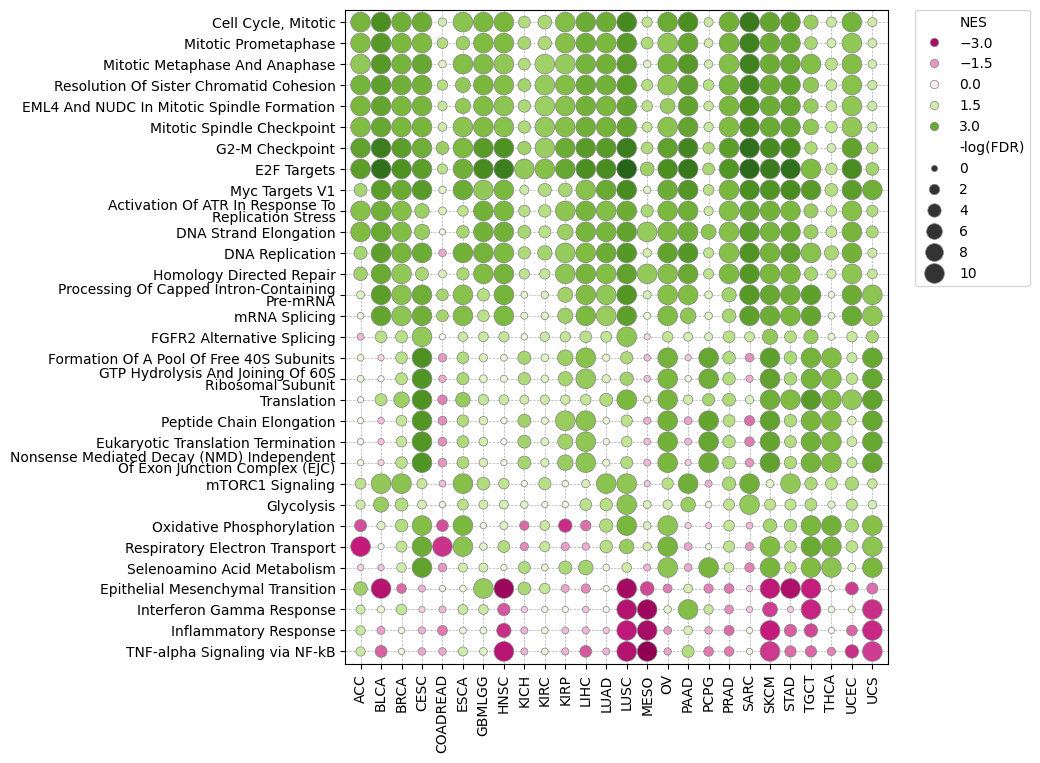

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from collections import defaultdict
from pandas.api.types import CategoricalDtype # for sorting based on the list

# Load data
invalid_studies = ["THYM", "CHOL", "DLBC", "COADREAD_old"] # ["PCPG", "UCS"]
root = "results_final_all/gene/dseq_results"
studies = sorted([study for study in os.listdir(root) if os.path.isdir(os.path.join(root, study)) and study not in invalid_studies])
df_lists = []
lists = []

for study in studies:
    df = pd.read_csv(f"{root}/{study}/gseapy.gene_set.prerank.report.csv")
    df_lists.append(df)
    lists.append(df["Term"].to_list())

# Find common names across all lists
common_names = set(lists[0])
for lst in lists[1:]:
    common_names &= set(lst)

# Create a dictionary to store the ranks of common names
name_ranks = defaultdict(list)

# Populate the dictionary with ranks from each list
for i, lst in enumerate(lists):
    for rank, name in enumerate(lst):
        if name in common_names:
            name_ranks[name].append(rank)

# Calculate the average rank for each common name
average_ranks = {name: np.mean(ranks) for name, ranks in name_ranks.items()}

# Sort the names by their average rank
sorted_names = sorted(average_ranks, key=average_ranks.get)

# # Select the top 20 names
# top_20_names = sorted_names[:20]

# top_20_names = top_20_names + mannual_pathways
# top_20_names = list(set(top_20_names))

# manually editing all the interesting pathways
top_20_names = [
    # Mitosis & Cell Cycle
    'Reactome_2022__Cell Cycle, Mitotic R-HSA-69278',
    'Reactome_2022__Mitotic Prometaphase R-HSA-68877',
    'Reactome_2022__Mitotic Metaphase And Anaphase R-HSA-2555396',
    # 'MSigDB_Hallmark_2020__Mitotic Spindle',
    'Reactome_2022__Resolution Of Sister Chromatid Cohesion R-HSA-2500257',
    'Reactome_2022__EML4 And NUDC In Mitotic Spindle Formation R-HSA-9648025',
    'Reactome_2022__Mitotic Spindle Checkpoint R-HSA-69618',
    'MSigDB_Hallmark_2020__G2-M Checkpoint',
    # 'Reactome_2022__Unattached Kinetochores Signal Amplification Via A MAD2 Inhibitory Signal R-HSA-141444', # maybe remove from here?
    'MSigDB_Hallmark_2020__E2F Targets',
    'MSigDB_Hallmark_2020__Myc Targets V1',

    # DNA Replication & Repair
    'Reactome_2022__Activation Of ATR In Response To Replication Stress R-HSA-176187',
    'Reactome_2022__DNA Strand Elongation R-HSA-69190',
    'Reactome_2022__DNA Replication R-HSA-69306',
    'Reactome_2022__Homology Directed Repair R-HSA-5693538',

    # Gene Expression and Protein Synthesis
    'Reactome_2022__Processing Of Capped Intron-Containing Pre-mRNA R-HSA-72203',
    'Reactome_2022__mRNA Splicing R-HSA-72172',
    'Reactome_2022__FGFR2 Alternative Splicing R-HSA-6803529',
    'Reactome_2022__Formation Of A Pool Of Free 40S Subunits R-HSA-72689',
    'Reactome_2022__GTP Hydrolysis And Joining Of 60S Ribosomal Subunit R-HSA-72706',
    'Reactome_2022__Translation R-HSA-72766',
    'Reactome_2022__Peptide Chain Elongation R-HSA-156902',
    'Reactome_2022__Eukaryotic Translation Termination R-HSA-72764',
    'Reactome_2022__Nonsense Mediated Decay (NMD) Independent Of Exon Junction Complex (EJC) R-HSA-975956',

    # Metabolism and Energy
    'MSigDB_Hallmark_2020__mTORC1 Signaling',
    # 'Reactome_2022__Metabolic Disorders Of Biological Oxidation Enzymes R-HSA-5579029',
    # 'Reactome_2022__Metabolism Of Steroid Hormones R-HSA-196071',
    'Reactome_2022__Glycolysis R-HSA-70171',
    'MSigDB_Hallmark_2020__Oxidative Phosphorylation',
    'Reactome_2022__Respiratory Electron Transport R-HSA-611105',
    'Reactome_2022__Selenoamino Acid Metabolism R-HSA-2408522',
    

    # Cancer Progression and Metastasis
    'MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition',

    # Immune Response and Inflammation
    'MSigDB_Hallmark_2020__Interferon Gamma Response',
    'MSigDB_Hallmark_2020__Inflammatory Response',
    'MSigDB_Hallmark_2020__TNF-alpha Signaling via NF-kB',

    # # Cell Signaling Pathways (maybe ignore this in the paper)
    
    # 'KEGG_2021_Human__PI3K-Akt signaling pathway',
    # 'KEGG_2021_Human__MAPK signaling pathway',
    # 'Reactome_2022__PTEN Regulation R-HSA-6807070',
    # 'KEGG_2021_Human__p53 signaling pathway',
]
# Define the categorical type with the desired order
cat_type = CategoricalDtype(categories=top_20_names, ordered=True)
print("Top 20 common names:", top_20_names)

# Function to clean term names
def clean_term(term):
    parts = term.split("__")
    main_term = parts[1] if len(parts) > 1 else term
    if parts[0] == "Reactome_2022" and "R-HSA-" in main_term:
        main_term = main_term.split("R-HSA-")[0].strip()
    return "\n".join(textwrap.wrap(main_term, width=42))

# Prepare data for plotting
plot_data = []

for study, df in zip(studies, df_lists):
    df_filtered = df[df["Term"].isin(top_20_names)].copy()

    # Convert 'Term' to the categorical type and Sort the DataFrame based on 'Term'
    df_filtered['Term'] = df_filtered['Term'].astype(cat_type)
    df_filtered = df_filtered.sort_values('Term')

    df_filtered["-log(FDR)"] = -np.log10(df_filtered["FDR q-val"].replace(0, 1e-10))
    df_filtered["Study"] = study
    df_filtered["Clean_Term"] = df_filtered["Term"].apply(clean_term)
    # df_filtered = df_filtered.sort_values(by="Clean_Term")
    plot_data.append(df_filtered)

plot_data = pd.concat(plot_data)
# plot_data = plot_data.sort_values(by="Clean_Term")

# Plot the dotplot
# plt.figure(figsize=(10, 6))
fig, ax =plt.subplots(1,1,figsize=(7, 8.5))
dotplot = sns.scatterplot(
    data=plot_data,
    x="Study",
    y="Clean_Term",
    size="-log(FDR)",
    hue="NES",
    palette="PiYG",
    sizes=(20, 200),
    edgecolor="gray",
    linewidth=0.5,
    ax=ax
)
# Adjust line spacing for y-axis tick labels
for label in ax.get_yticklabels():
    label.set_linespacing(0.8)  # Reduce line spacing
    
ax.margins(y=0.02, x=0.03)
dotplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("")
# plt.title('Dotplot of Top Common Terms across Studies')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_axisbelow(True)

# plt.tight_layout()

plt.savefig(f"{root}/dseq_results_complete_wide.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)
plt.savefig(f"{root}/dseq_results_complete_wide.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
top_20_names = [
# Mitosis related
'Reactome_2022__Mitotic Anaphase R-HSA-68882',
'MSigDB_Hallmark_2020__Mitotic Spindle0',
'Reactome_2022__Mitotic Metaphase And Anaphase R-HSA-2555396',
'Reactome_2022__Cell Cycle, Mitotic R-HSA-69278',
'Reactome_2022__Mitotic Prometaphase R-HSA-68877',
'Reactome_2022__EML4 And NUDC In Mitotic Spindle Formation R-HSA-9648025',
'Reactome_2022__Resolution Of Sister Chromatid Cohesion R-HSA-2500257',

# Cell Cycle Checkpoints
'Reactome_2022__Unattached Kinetochores Signal Amplification Via A MAD2 Inhibitory Signal R-HSA-141444',
'MSigDB_Hallmark_2020__G2-M Checkpoint',
'Reactome_2022__Mitotic Spindle Checkpoint R-HSA-69618',


# DNA replication and stress
'Reactome_2022__Activation Of ATR In Response To Replication Stress R-HSA-176187',
'Reactome_2022__Homology Directed Repair R-HSA-5693538',
'Reactome_2022__DNA Strand Elongation R-HSA-69190',
'Reactome_2022__DNA Replication R-HSA-69306',

# Protein Synthesis and Translation
'Reactome_2022__GTP Hydrolysis And Joining Of 60S Ribosomal Subunit R-HSA-72706',
'Reactome_2022__Eukaryotic Translation Termination R-HSA-72764',
'KEGG_2021_Human__Ribosome',
'Reactome_2022__Translation R-HSA-72766',
'Reactome_2022__Formation Of A Pool Of Free 40S Subunits R-HSA-72689',
'Reactome_2022__Peptide Chain Elongation R-HSA-156902',

# RNA Processing and Quality Control
'KEGG_2021_Human__Spliceosome',
'Reactome_2022__Processing Of Capped Intron-Containing Pre-mRNA R-HSA-72203',
'Reactome_2022__Nonsense Mediated Decay (NMD) Independent Of Exon Junction Complex (EJC) R-HSA-975956',

# Metabolism
'Reactome_2022__Selenoamino Acid Metabolism R-HSA-2408522',
'Reactome_2022__Metabolic Disorders Of Biological Oxidation Enzymes R-HSA-5579029',
'Reactome_2022__Metabolism Of Steroid Hormones R-HSA-196071',

# Energy Metabolism
'MSigDB_Hallmark_2020__Oxidative Phosphorylation',
'Reactome_2022__Respiratory Electron Transport R-HSA-611105',

# Immune Response and Inflammation
'MSigDB_Hallmark_2020__Interferon Gamma Response',
'MSigDB_Hallmark_2020__Inflammatory Response',
'MSigDB_Hallmark_2020__TNF-alpha Signaling via NF-kB',

# Cancer Progression and Metastasis
'MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition',

# Cell Proliferation and Cell Cycle Regulation
'MSigDB_Hallmark_2020__Myc Targets V1',
'MSigDB_Hallmark_2020__E2F Targets',
'KEGG_2021_Human__PI3K-Akt signaling pathway',
'KEGG_2021_Human__MAPK signaling pathway',
'Reactome_2022__PTEN Regulation R-HSA-6807070',
'KEGG_2021_Human__Wnt signaling pathway',
'KEGG_2021_Human__p53 Signaling Pathway'
'KEGG_2021_Human__Hippo Signaling Pathway'
]

In [ ]:
top_20_names_grouped = [
    # Mitosis & Cell Cycle
    'Reactome_2022__Cell Cycle, Mitotic R-HSA-69278',
    'Reactome_2022__Mitotic Metaphase And Anaphase R-HSA-2555396',
    'Reactome_2022__Mitotic Prometaphase R-HSA-68877',
    'MSigDB_Hallmark_2020__Mitotic Spindle',
    'Reactome_2022__EML4 And NUDC In Mitotic Spindle Formation R-HSA-9648025',
    'Reactome_2022__Resolution Of Sister Chromatid Cohesion R-HSA-2500257',
    'MSigDB_Hallmark_2020__G2-M Checkpoint',
    'Reactome_2022__Unattached Kinetochores Signal Amplification Via A MAD2 Inhibitory Signal R-HSA-141444',
    'Reactome_2022__Mitotic Spindle Checkpoint R-HSA-69618',
    'MSigDB_Hallmark_2020__E2F Targets',
    'MSigDB_Hallmark_2020__Myc Targets V1',

    # DNA Replication & Repair
    'Reactome_2022__Activation Of ATR In Response To Replication Stress R-HSA-176187',
    'Reactome_2022__DNA Strand Elongation R-HSA-69190',
    'Reactome_2022__DNA Replication R-HSA-69306',
    'Reactome_2022__Homology Directed Repair R-HSA-5693538',

    # Gene Expression and Protein Synthesis
    'Reactome_2022__GTP Hydrolysis And Joining Of 60S Ribosomal Subunit R-HSA-72706',
    'KEGG_2021_Human__Ribosome',
    'Reactome_2022__Eukaryotic Translation Termination R-HSA-72764',
    'Reactome_2022__Translation R-HSA-72766',
    'Reactome_2022__Formation Of A Pool Of Free 40S Subunits R-HSA-72689',
    'Reactome_2022__Peptide Chain Elongation R-HSA-156902',
    'Reactome_2022__Processing Of Capped Intron-Containing Pre-mRNA R-HSA-72203',
    'KEGG_2021_Human__Spliceosome',
    'Reactome_2022__Nonsense Mediated Decay (NMD) Independent Of Exon Junction Complex (EJC) R-HSA-975956',

    # Metabolism and Energy
    'Reactome_2022__Selenoamino Acid Metabolism R-HSA-2408522',
    'Reactome_2022__Metabolic Disorders Of Biological Oxidation Enzymes R-HSA-5579029',
    'Reactome_2022__Metabolism Of Steroid Hormones R-HSA-196071',
    'MSigDB_Hallmark_2020__Oxidative Phosphorylation',
    'Reactome_2022__Respiratory Electron Transport R-HSA-611105',

    # Cancer Progression and Metastasis
    'MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition',

    # Immune Response and Inflammation
    'MSigDB_Hallmark_2020__Interferon Gamma Response',
    'MSigDB_Hallmark_2020__Inflammatory Response',
    'MSigDB_Hallmark_2020__TNF-alpha Signaling via NF-kB',

    # Cell Signaling Pathways
    'KEGG_2021_Human__PI3K-Akt signaling pathway',
    'KEGG_2021_Human__MAPK signaling pathway',
    'Reactome_2022__PTEN Regulation R-HSA-6807070',
    'KEGG_2021_Human__p53 signaling pathway',
]


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,-log(FDR),Study,Clean_Term
